# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


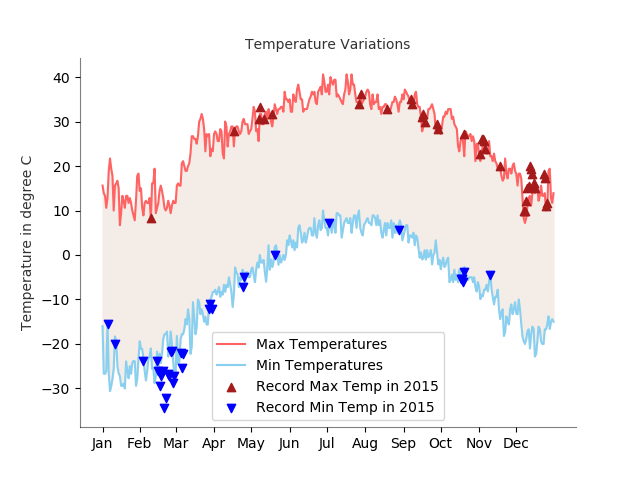

In [58]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

%matplotlib notebook

remove_col_names = []
fig = plt.figure()

def my_func(x):
    global remove_col_names
    if x.split("-")[1] == "02" and x.split("-")[2] == "29":
        remove_col_names.append(x)
    return x

def leaflet_plot_stations(binsize, hashid):
    global remove_col_names
    df = pd.read_csv('more_data.csv'.format(binsize))
    new_df = df.copy()
    new_df['Date'].apply(my_func)
    new_df['Data_Value'] = new_df['Data_Value'].apply(lambda x: float(x)/10)
    for date in remove_col_names:
        new_df = new_df[new_df["Date"] != date]
        
    new_df['Year'] = new_df['Date'].apply(lambda x:x.split("-")[0])
    range_df = new_df[(new_df['Year'] >= "2005") & (new_df['Year'] <= "2014")]
    alternate_df = new_df[(new_df['Year'] == "2015")]
    
    range_df = range_df.groupby(by='Date')
    alternate_df = alternate_df.groupby(by='Date')

    new_df = pd.DataFrame()
    new_df['max'] = range_df['Data_Value'].max()
    new_df['min'] = range_df['Data_Value'].min()
    new_df = new_df.reset_index()
    new_df['Day'] = new_df['Date'].apply(lambda x: x.split("-")[2])
    new_df['Month'] = new_df['Date'].apply(lambda x: x.split("-")[1])
    new_df['Year'] = new_df['Date'].apply(lambda x: x.split("-")[0])
    new_df = new_df.drop(['Date'], axis=1)
    
    months = []
    start = datetime.date(2000, 1, 1)
    for delta in range(1, 366):
        delta_time = datetime.timedelta(1)
        start = start + delta_time
        months.append(start.strftime('%b'))
    
    initial_month = "Jan"
    for day in range(1, len(months)):
        if months[day] == initial_month:
            months[day] = ""
        else:
            initial_month = months[day]            
    
    max_data_df = pd.DataFrame()
    min_data_df = pd.DataFrame()
    years = [str(year) for year in range(2005, 2015)]
    for i in years:
        temp_df = new_df[new_df['Year'] == i]
        max_data_df[i] = temp_df['max'].values
        min_data_df[i] = temp_df['min'].values

    max_data_df['max'] = max_data_df.max(axis=1)
    min_data_df['min'] = min_data_df.min(axis=1)

    max_data_df['new_max'] = alternate_df['Data_Value'].max().values
    min_data_df['new_min'] = alternate_df['Data_Value'].min().values
    
    max_data_df = max_data_df.drop(years, axis=1)
    min_data_df = min_data_df.drop(years, axis=1)
    
    ax = plt.gca()
    plt.xticks([x for x in range(0, len(max_data_df))], months)
    plt.plot([x for x in range(0, len(max_data_df))], max_data_df['max'].values, color="#ff6363", zorder=1, label='Max Temperatures')
    
    plt.plot([x for x in range(0, len(min_data_df))], min_data_df['min'].values, color="#89cff0", zorder=1, label='Min Temperatures')
    plt.fill_between([x for x in range(0, len(max_data_df))], max_data_df['max'].values, min_data_df['min'].values, color='#f4ece6')

    max_data_df = max_data_df[max_data_df['new_max'] > max_data_df['max']]
    min_data_df = min_data_df[min_data_df['new_min'] < min_data_df['min']]

    plt.scatter(max_data_df.index.values, max_data_df['new_max'], c='#a51a1a', marker='^', zorder=2, label='Record Max Temp in 2015')
    plt.scatter(min_data_df.index.values, min_data_df['new_min'], c='blue', marker='v', zorder=2, label='Record Min Temp in 2015')
    
    for spline in zip(ax.spines, ax.spines.values()):
        if spline[0] == "top" or spline[0] == "right":
            spline[1].set_visible(False)
        else:
            spline[1].set_alpha(0.5)
            
    plt.title('Temperature Variations', alpha=0.8, fontsize=10)
    plt.ylabel('Temperature in degree C', alpha=0.8)
    
    ticks = ax.xaxis.get_major_ticks()
    for tick in ticks:
        if tick.label1.get_text() != "":
            tick.set_visible(True)
        else:
            tick.set_visible(False)
            
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    return 

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')
